In [82]:
#import datasets
from aif360.datasets import StandardDataset
from aif360.datasets import CompasDataset
#import fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt


#### Variant of new metric:

- bi ranges 0,1,-1

In [83]:
def var_new_metric(arr_pred, arr_true, arr_grp):
    grp_priv = [[], []]
    grp_unpriv = [[], []]

    #j is the number of unique groups in arr_grp - an implicit parameter.
    j = len(set(arr_grp))
    #print("total number of unique groups: ", j)

    for i, label in enumerate(arr_grp):
        #for privileged class
        if label == 1.0:
            #add the corresponding prediction + gt label for that class using the index associated with that label
            grp_priv[0].append(arr_pred[i])
            grp_priv[1].append(arr_true[i])
        
        #for unprivileged class 
        else:
            grp_unpriv[0].append(arr_pred[i])
            grp_unpriv[1].append(arr_true[i])
    
    #print("Privileged group: ", grp_priv)
    #print("Unprivileged group: ", grp_unpriv)
    
    priv_indiv_bi = [] #stores individual benefit value of each instance
    priv_grp_bi = 0 #tracks total benefit for group
    
    #1. for each index in a group calculate the benefit, bi
    for pred, gt in zip(grp_priv[0], grp_priv[1]):
        #calculate benefit for each instance in a group with new range, 0,1,-1 
        indiv_benefit = (int(pred) - int(gt)) 
        
        #2. Sum the total benefit of each group
        priv_grp_bi += indiv_benefit
        
        #3. divide by size of group which is total number of instances in each group.
        priv_av_bi = priv_grp_bi / len(grp_priv[0]) #[0] has predictions which will give that number.

        #store individual benefit of each instance in a list
        priv_indiv_bi.append(indiv_benefit)
        
    #print("all bi scores for privileged instances:\n", priv_indiv_bi)
    #print(priv_grp_bi)
    #print(priv_av_bi)

    unpriv_indiv_bi = []
    unpriv_grp_bi = 0
    for pred, gt in zip(grp_unpriv[0], grp_unpriv[1]):
        indiv_benefit = (int(pred) - int(gt))  
        unpriv_grp_bi += indiv_benefit
        unpriv_av_bi = unpriv_grp_bi / len(grp_priv[0])
        unpriv_indiv_bi.append(indiv_benefit)

    #print("\nall bi scores for unprivileged instances:\n", unpriv_indiv_bi)
    #print(unpriv_grp_bi)
    #print(unpriv_av_bi)
   
    #4. division result is divided by the sum of g1 and g2 - J
    result = int(priv_av_bi + unpriv_av_bi) / j

    #print("new metric value: ", result)
    #return  priv_av_bi, unpriv_av_bi to see individual benefit for each group type
    return result

#var_new_metric(predictions, ground_truth, grp_membership)


In [84]:
#function to generate arrays synthetically by using fixed distributions:

#function takes in the size of array and the type of distribution to generate
#also takes as input the order for correct 0s and 1s placement.
def gen_fixed_dist_combinations(num_of_instances, 
                                grp_dist, true_dist, pred_dist, 
                                grp_order='asc', true_order='asc', pred_order='asc',
                                randomise=False):
    
    #a dictionary that stores the types of expected distributions and maps to their corresp probabilties
    distribution_mapping = {"50/50": (0.5, 0.5), #50% 0s 50% 1s
                            "80/20": (0.8, 0.2), #80% 0s 20% 1s
                            "90/10": (0.9, 0.1), #90% 0s 10% 1s
                            "20/80": (0.2, 0.8), #20% 0s 80% 1s
                            "10/90":(0.1, 0.9)} #10% 0s 90% 1s

    #get the given parameters of probabilties for each distribution from the dict
    group_probability = distribution_mapping.get(grp_dist)
    gt_probability = distribution_mapping.get(true_dist)
    pred_probability = distribution_mapping.get(pred_dist)

    if randomise:
        arr_grp = np.random.choice([0,1], size=num_of_instances, p=group_probability)
        arr_true = np.random.choice([0,1], size=num_of_instances, p=gt_probability)
        arr_pred = np.random.choice([0,1], size=num_of_instances, p=pred_probability)

    else:
        #calculations for fixing the 0s and 1s for each array using probabilities and array size
        group_zeroes =  int(num_of_instances * group_probability[0])
        group_ones =  num_of_instances - group_zeroes
    
        true_zeroes = int(num_of_instances * gt_probability[0])
        true_ones = num_of_instances - true_zeroes
    
        pred_zeroes = int(num_of_instances * pred_probability[0])
        pred_ones = num_of_instances - pred_zeroes

        #create predictions array based on desired order of 0s and 1s.
        if pred_order == 'asc':
            arr_pred = np.array([0] * pred_zeroes + [1] * pred_ones)
        elif pred_order == 'desc':
            arr_pred = np.array([1] * pred_zeroes + [0] * pred_ones)
        else:
            raise ValueError("prediction array order must be 'asc' or 'desc'")
    
        #create ground truth labels array based on desired order of 0s and 1s.
        if true_order == 'asc':
            arr_true = np.array([0] * true_zeroes + [1] * true_ones)
        elif true_order == 'desc':
            arr_true = np.array([1] * true_zeroes + [0] * true_ones)
        else:
            raise ValueError("prediction array order must be 'asc' or 'desc'")
    
        #create group memberships array based on desired order of 0s and 1s.
        if grp_order == 'asc':
            arr_grp = np.array([0] * group_zeroes + [1] * group_ones)
        elif grp_order == 'desc':
            arr_grp = np.array([1] * group_zeroes + [0] * group_ones)
        else:
            raise ValueError("group membership array order must be 'asc' or 'desc'")
    
    return arr_grp, arr_true, arr_pred  



arr_grp, arr_true, arr_pred = gen_fixed_dist_combinations(10, 
                                                          "80/20", 
                                                          "50/50", 
                                                          "80/20", 
                                                          grp_order='asc',
                                                          true_order='asc', 
                                                          pred_order='asc', 
                                                          randomise=False)

arr_grp_desc, arr_true_asc, arr_pred_asc = gen_fixed_dist_combinations(10, 
                                                          "80/20", 
                                                          "50/50", 
                                                          "80/20",
                                                        grp_order='desc',
                                                        true_order='asc',
                                                        pred_order='asc', 
                                                        randomise=False)

arr_grp_rand, arr_true_rand, arr_pred_rand = gen_fixed_dist_combinations(10, 
                                                          "80/20", 
                                                          "50/50", 
                                                          "80/20", 
                                                          randomise=True)

print("group membership array: ", arr_grp)
# print("predictions array: ", arr_pred)
# print("grount truth labels array: ", arr_true)


# #to check if that ordering feature even does anything
print("group membership with desc feature: ", arr_grp_desc)
# print("predictions with asc feature: ", arr_pred_asc)
# print("grount truth labels with asc feature: ", arr_true_asc)

# print("group membership with randomness: ", arr_grp_rand)
# print("predictions with randomness: ", arr_pred_rand)
# print("grount truth labels with randomness: ", arr_true_rand)


#checking to see if the desc/asc feature changes the score for the metric:
print("metric score for fixed arrays: ", new_metric(arr_grp, arr_true, arr_pred))
print("metric score for fixed arrays with group desc flag: ", new_metric(arr_grp_desc, arr_true_asc, arr_pred_asc))
print("metric score for randomised arrays: ",new_metric(arr_grp_rand, arr_true_rand, arr_pred_rand))

group membership array:  [0 0 0 0 0 0 0 0 1 1]
group membership with desc feature:  [1 1 1 1 1 1 1 1 0 0]
metric score for fixed arrays:  -0.5
metric score for fixed arrays with group desc flag:  0.5
metric score for randomised arrays:  -1.5


In [80]:
from sklearn.metrics import balanced_accuracy_score

def balanced_accuracy(arr_true, arr_pred):
    y_true = arr_true
    y_pred = arr_pred
    return balanced_accuracy_score(y_true, y_pred)

In [81]:
from aif360.datasets import BinaryLabelDataset 
from aif360.metrics import ClassificationMetric

def aif360_metric_object(num_of_instances, arr_grp, arr_true, arr_pred, seed=42):
    
    # synthetic feature data just to comply with AIF360 formatting to apply metric.
    np.random.seed(seed)
    features = pd.DataFrame({
        'feature1': np.random.rand(num_of_instances),
        'feature2': np.random.rand(num_of_instances),
        'race': np.random.randint(0, 2, num_of_instances)  # placeholder protected attribute
    })

    features['race'] = arr_grp #protected attribute to represent the group membership array
    
    #these will be the variables to store the generated arrays with varying distributions 
    #these changing arrays will show the changing score of each metric being applied 

    data_true = features.copy() #dataframe with true labels
    data_true['label'] = arr_true
    
    data_pred = features.copy() #dataframe with predicted labels
    data_pred['label'] = arr_pred
    
    # Create BinaryLabelDataset objects for true and predicted datasets
    dataset_true = BinaryLabelDataset(df=data_true, label_names=['label'], protected_attribute_names=['race'])
    dataset_pred = BinaryLabelDataset(df=data_pred, label_names=['label'], protected_attribute_names=['race'])
    
    privileged_groups = [{'race': 1}]  # represents the majority group
    unprivileged_groups = [{'race': 0}]  # represents the minority group
    
    metric = ClassificationMetric(dataset_true, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    return metric
    
#aif360_metric = aif360_metric_object(num_of_instances, arr_grp, arr_true, arr_pred)

In [78]:
from aif360.datasets import BinaryLabelDataset 
from aif360.metrics import ClassificationMetric
import itertools 

def automate_analysis(num_of_instances, randomise=False):
  
    dist_types = ["50/50", "80/20", "90/10", "20/80", "10/90"]
    order_type = ["asc", "desc"] #for more variation of arrays
 
    results = []

    #number 43 and not convention number 42 because the latter gives a division by zero error
    if randomise:
        np.random.seed(43)

    for (grp_dist, true_dist, pred_dist, grp_order, true_order, pred_order) in itertools.product(dist_types, dist_types, dist_types,
                                                                                                order_type, order_type, order_type):
        #generate array for current combination
        arr_grp, arr_true, arr_pred = gen_fixed_dist_combinations(num_of_instances, 
                                                                  grp_dist=grp_dist, 
                                                                  true_dist=true_dist, 
                                                                  pred_dist=pred_dist, 
                                                                  grp_order=grp_order, 
                                                                  true_order=true_order, 
                                                                  pred_order=pred_order,
                                                                  randomise=randomise)
        balanced_accuracy_score = balanced_accuracy(arr_true, arr_pred)
        var_custom_metric = var_new_metric(arr_grp, arr_true, arr_pred)
        
        aif360_metric = aif360_metric_object(num_of_instances, arr_grp, arr_true, arr_pred, seed=42)
        gei_score = aif360_metric.generalized_entropy_index()
        statistical_parity_diff = aif360_metric.mean_difference()
        disparate_impact = aif360_metric.disparate_impact()
        eq_opp_diff =  aif360_metric.equal_opportunity_difference()
        av_odds_diff = aif360_metric.average_odds_difference()
        
        results.append({
            "grp_dist":grp_dist,
            "true_dist": true_dist,
            "pred_dist": pred_dist,
            "grp_order": grp_order,
            "true_order": true_order,
            "pred_order": pred_order,
            "balanced accuracy score": balanced_accuracy_score,
            "variant_custom_metric score": var_custom_metric,                    
            "gei_score": gei_score,
            "statistical_parity_diff":statistical_parity_diff,
            "disparate_impact": disparate_impact,
            "eq_opp_diff":eq_opp_diff, 
            "av_odds_diff":av_odds_diff 
        })

    #create pandas dataframe from the results list
    metrics_df = pd.DataFrame(results)
    return metrics_df

num_of_instances = 100
fixed_metrics_scores_table = automate_analysis(num_of_instances, randomise=False)
fixed_latex_table = fixed_metrics_scores_table.to_latex(index=False)

pd.set_option('display.max_rows', None) #to display all 1000 rows of table.
#print(fixed_metrics_scores_table)

random_metrics_scores_table = automate_analysis(num_of_instances, randomise=True)
random_latex_table = random_metrics_scores_table.to_latex(index=False)
#print(random_metrics_scores_table)
#print(random_latex_table)
                

In [133]:
#1. Function to plot each individual metrics based on their distributions
#to get zoomed in insight of metric behaviour based on varied arrays.

def plots_per_metric(df, array_variation='grp_dist', fix_grp=None, fix_true=None, fix_pred=None, metric='metric_score'):
    if array_variation=='grp_dist':
        if fix_true is not None:
            df = df[df['true_dist']==fix_true]
        if fix_pred is not None:
            df = df[df['pred_dist']==fix_pred]
        x_axis = 'grp_dist'
    elif array_variation=='true_dist':
        if fix_grp is not None:
             df = df[df['grp_dist']==fix_grp]
        if fix_pred is not None:
            df = df[df['pred_dist']==fix_pred]
        x_axis = 'true_dist'
    elif array_variation=='pred_dist':
        if fix_grp is not None:
            df = df[df['grp_dist']==fix_grp]
        if fix_true is not None:
            df = df[df['true_dist']==fix_true]
        x_axis = 'pred_dist'
    else:
        raise ValueError("array variations can be either 'grp_dist', 'true_dist' or 'pred_dist'")

    #need to group by the chosen distribution (the parameter being varied) 
    #and calculate the mean metric score to get a single representative value for that distribution
    summary = df.groupby(x_axis)[metric].mean().reset_index()

    #need to also specifiy which arrays were kept fixed and by what dist type.
    fixed_arrays = []
    if fix_grp is not None and array_variation != 'grp_dist':
        fixed_arrays.append(f"grp_dist = {fix_grp}")
    if fix_true is not None and array_variation != 'true_dist':
        fixed_arrays.append(f"true_dist = {fix_true}")
    if fix_pred is not None and array_variation != 'pred_dist':
        fixed_arrays.append(f"pred_dist = {fix_pred}")
    fixed_text = ", ".join(fixed_arrays)
    
    title = f"How {metric} changes when {x_axis} is varied"
    if fixed_text:
        title += f"\n({fixed_text} fixed)"
    
    plt.figure(figsize=(8, 6))
    plt.scatter(summary[x_axis], summary[metric], marker='o', linestyle='-')
    plt.xlabel(f"Each distribution type for {x_axis}")
    plt.ylabel(metric)
    plt.title(title)

    #to get the range of scores
    max_score_value = summary[metric].max()
    plt.ylim(0, max_score_value + 0.3 * max_score_value) #with additional upperlimit range to capture all datapoints
    plt.grid(True)
    plt.show()


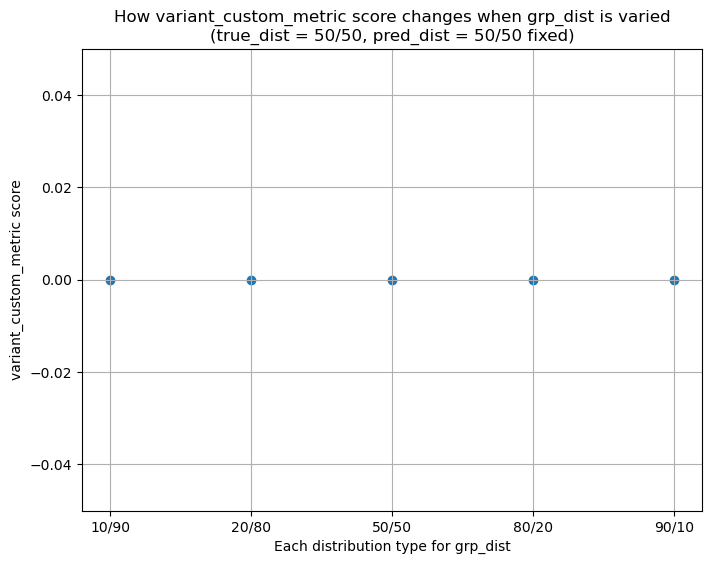

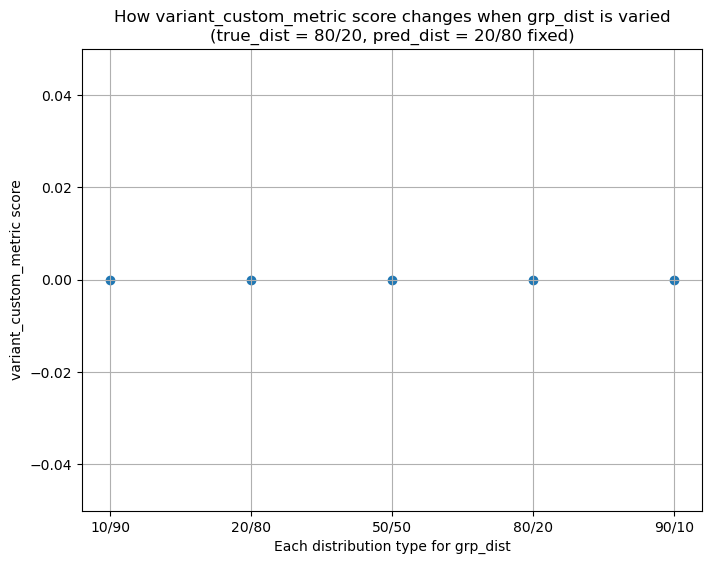

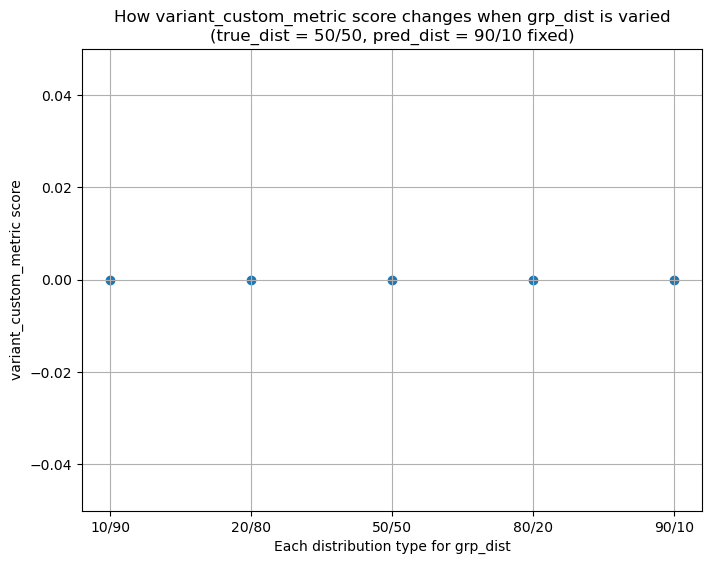

In [134]:
#fixed arrays test
plots_per_metric(fixed_metrics_scores_table, array_variation='grp_dist', fix_true="50/50", fix_pred="50/50", metric='variant_custom_metric score')
plots_per_metric(fixed_metrics_scores_table, array_variation='grp_dist', fix_true="80/20", fix_pred="20/80", metric='variant_custom_metric score')
plots_per_metric(fixed_metrics_scores_table, array_variation='grp_dist', fix_true="50/50", fix_pred="90/10", metric='variant_custom_metric score')


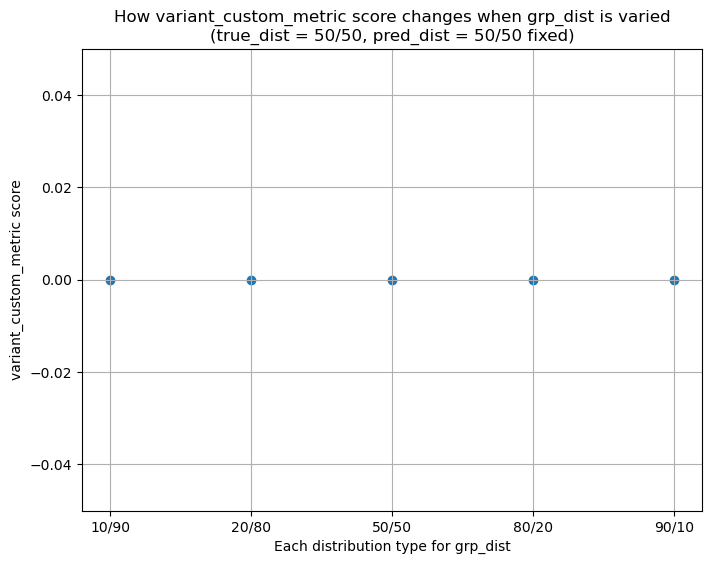

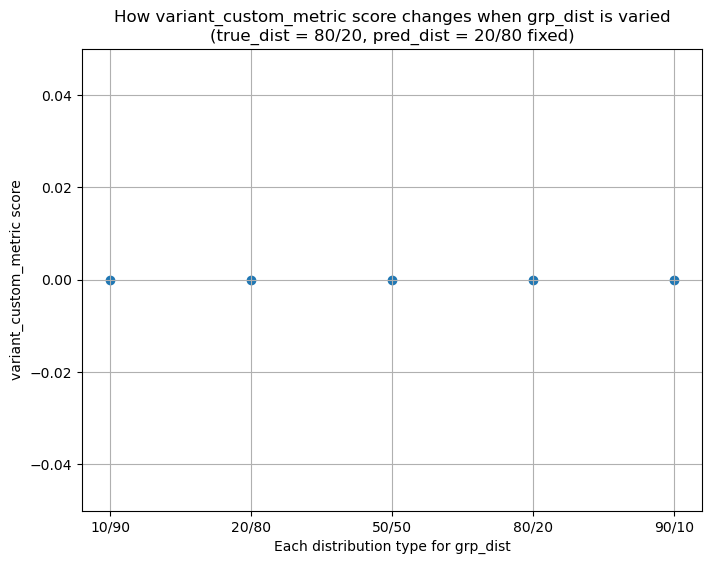

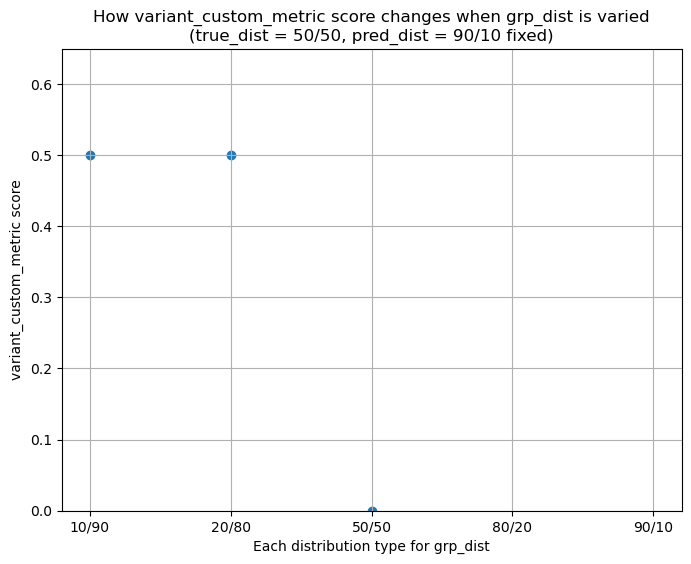

In [135]:
#random arrays test
#when varying group array distribution but keeping predictions and true labels fixed 50/50 - i.e. there is 50/50 chance of pos or neg outcome
plots_per_metric(random_metrics_scores_table, array_variation='grp_dist', fix_true="50/50", fix_pred="50/50", metric='variant_custom_metric score')
plots_per_metric(random_metrics_scores_table, array_variation='grp_dist', fix_true="80/20", fix_pred="20/80", metric='variant_custom_metric score')
plots_per_metric(random_metrics_scores_table, array_variation='grp_dist', fix_true="50/50", fix_pred="90/10", metric='variant_custom_metric score')


### BAC scores for group array varuing distributions:

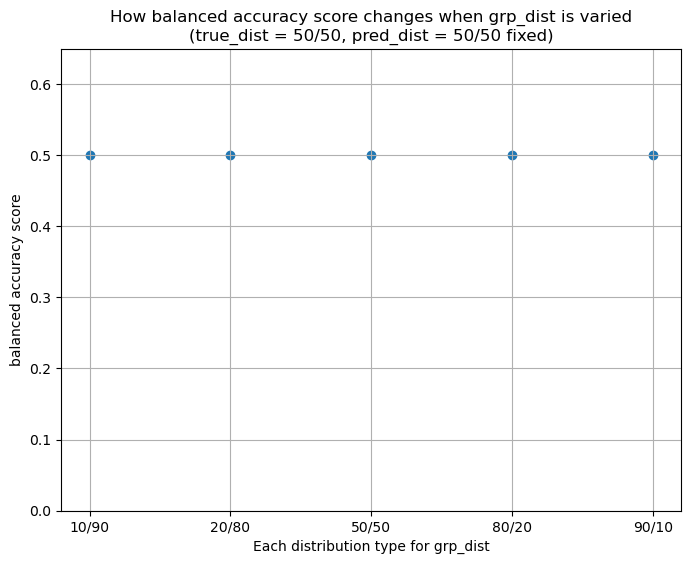

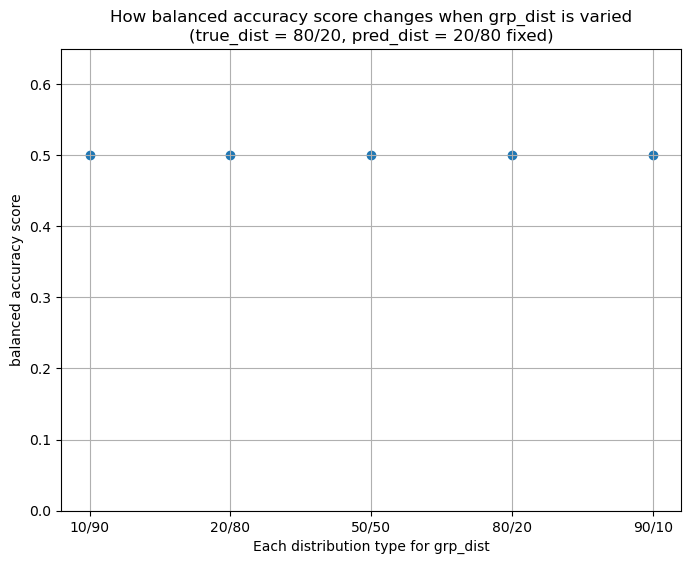

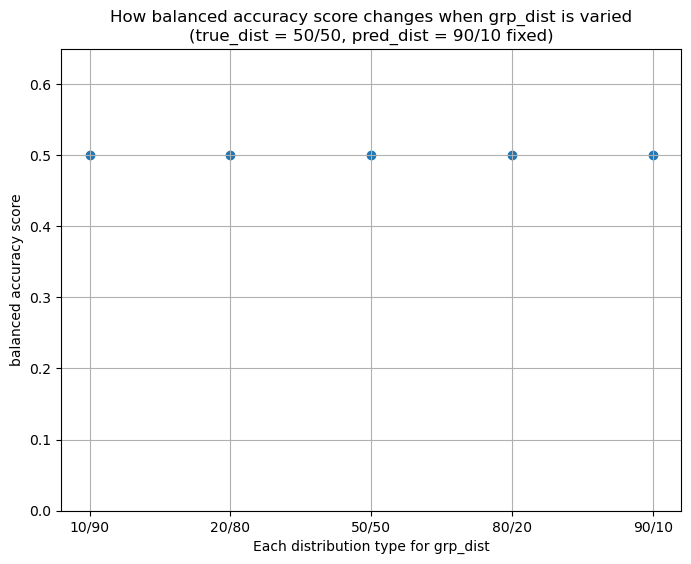

In [138]:
#BAC fixed arrays
plots_per_metric(fixed_metrics_scores_table, array_variation='grp_dist', fix_true="50/50", fix_pred="50/50", metric='balanced accuracy score')
plots_per_metric(fixed_metrics_scores_table, array_variation='grp_dist', fix_true="80/20", fix_pred="20/80", metric='balanced accuracy score')
plots_per_metric(fixed_metrics_scores_table, array_variation='grp_dist', fix_true="50/50", fix_pred="90/10", metric='balanced accuracy score')


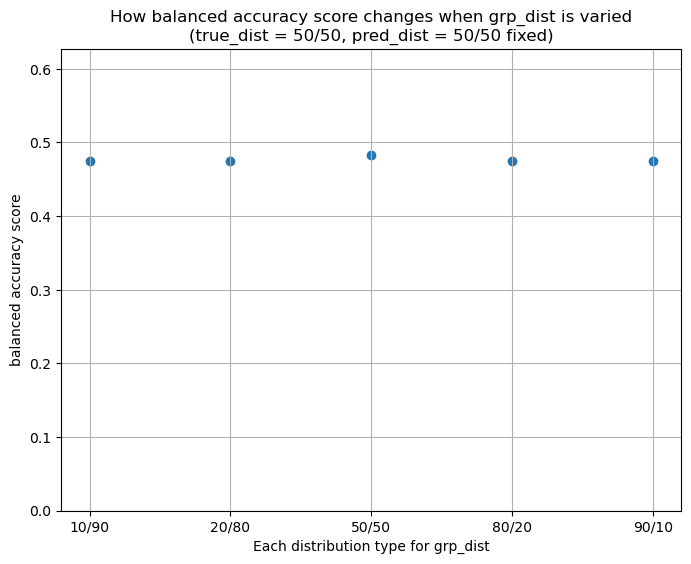

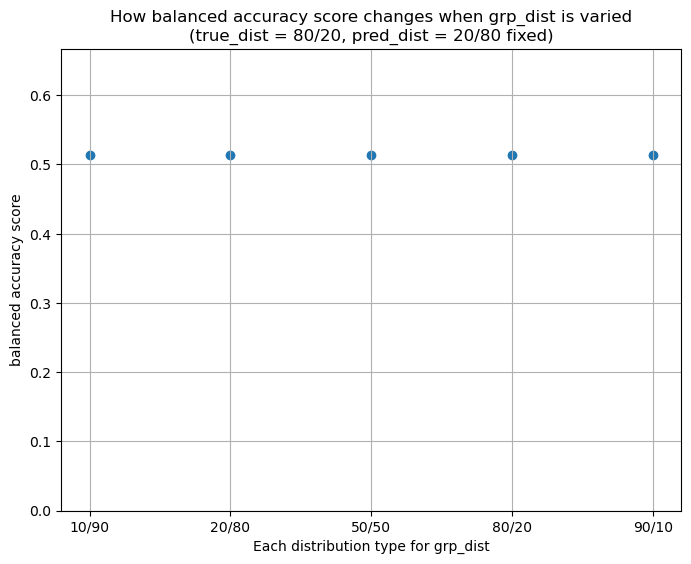

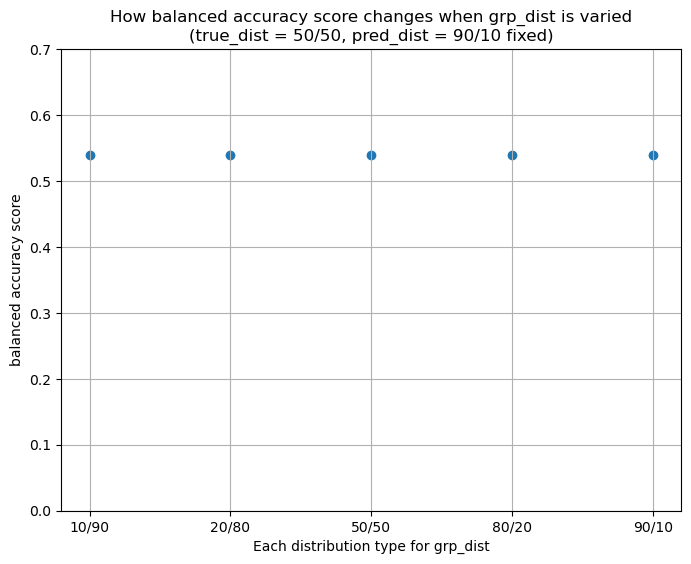

In [139]:
#BAC randomised arrays
plots_per_metric(random_metrics_scores_table, array_variation='grp_dist', fix_true="50/50", fix_pred="50/50", metric='balanced accuracy score')
plots_per_metric(random_metrics_scores_table, array_variation='grp_dist', fix_true="80/20", fix_pred="20/80", metric='balanced accuracy score')
plots_per_metric(random_metrics_scores_table, array_variation='grp_dist', fix_true="50/50", fix_pred="90/10", metric='balanced accuracy score')


In [136]:
def plot_comparisons(df, x_dist, y1_metric_score, y2_metric_score,
                                     y1_metric_label='custom_metric', y2_metric_label='aif_metric',
                                     title='Metric Behavior with Varying Distribution'):

    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax2 = ax1.twinx()
    
    #Plot the custom metric as blue scatter points
    ax1.scatter(df[x_dist], df[y1_metric_score], color='tab:blue', alpha=0.7, label=y1_metric_label)
    ax1.set_ylabel(y1_metric_label, color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim([-3, max(df[y1_metric_score]) + 1])
    
    #Plot the existing aif360 metric as red scatter points
    ax2.scatter(df[x_dist], df[y2_metric_score], color='tab:red', alpha=0.7, label=y2_metric_label)
    ax2.set_ylabel(y2_metric_label, color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim([-5, 4])
    
    ax1.set_xlabel(x_dist)
    plt.title(title)
    fig.tight_layout()
    plt.show()

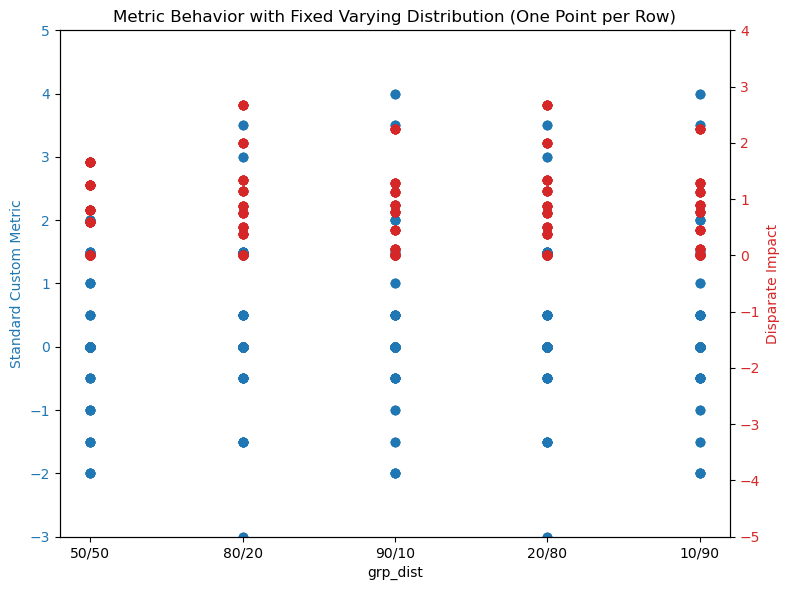

In [137]:
#for dataframe with fixed arrays.
plot_comparisons(
    fixed_metrics_scores_table, 
    x_dist="grp_dist",
    y1_metric_score="variant_custom_metric score",
    y2_metric_score="disparate_impact",
    y1_metric_label="Standard Custom Metric",
    y2_metric_label="Disparate Impact",
    title="Metric Behavior with Fixed Varying Distribution (One Point per Row)"
)

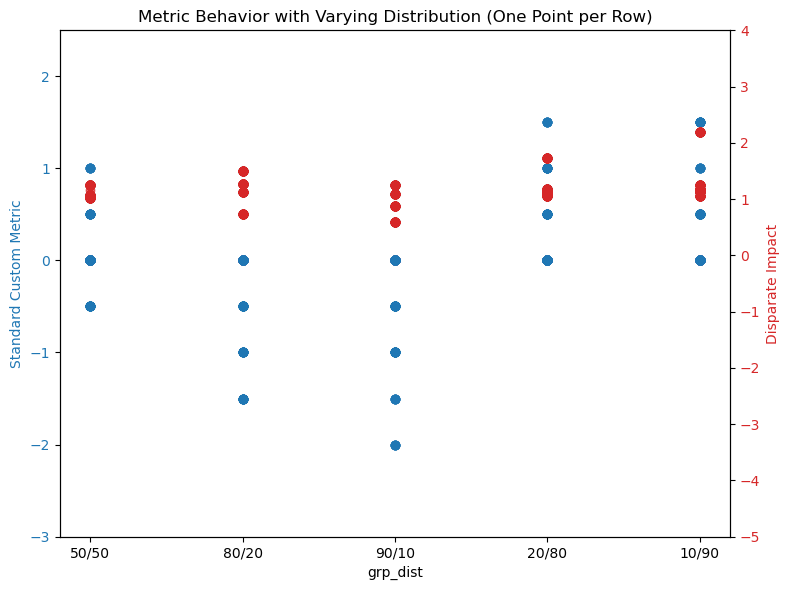

In [121]:
#for dataframe with randomised arrays.
plot_comparisons(
    random_metrics_scores_table, 
    x_dist="grp_dist",
    y1_metric_score="variant_custom_metric score",
    y2_metric_score="disparate_impact",
    y1_metric_label="Standard Custom Metric",
    y2_metric_label="Disparate Impact",
    title="Metric Behavior with Varying Distribution (One Point per Row)"
)

### confusions:

- why are the points much less than what is in the standard df???
- and why do the scores go upto 8 for fixed arrays???